<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/WIP_misza222_plant_pathology_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideas:
- Create a baseline with ability to configure model (arch, augmentations)
- Way to record results (MLFlow?)
- Create 2 classification models - one for scab and one for rust and compare it with multi classification model of 3 classes (healthy, scab, rust)
- add augmentations

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip uninstall fastai -q -y
!pip install fastai -q

     |████████████████████████████████| 194kB 12.8MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 


In [3]:
import fastai
print(fastai.__version__)

2.1.7


In [3]:
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score

ModuleNotFoundError: ignored

In [1]:
PATH = Path('/content/drive/MyDrive/fastai/data/plant-pathology/')
DATA_DIR = PATH
IMG_DIR = PATH/'images'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
SS_CSV = 'sample_submission.csv'

NameError: ignored

In [2]:
DATA_DIR.ls()

NameError: ignored

In [13]:
#There are 3642 train and test images in the images folder
IMG_DIR.ls()

(#3642) [Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1733.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1734.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1713.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1738.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1735.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_173.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1769.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_179.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1786.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1754.jpg')...]

# Understanding the data

In [14]:
#lets take a look at the train csv
train_df = pd.read_csv(DATA_DIR/TRAIN_CSV)
test_df = pd.read_csv(DATA_DIR/TEST_CSV)

In [15]:
#there are 4 classes - multiclass problem
train_df.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


#### Q: Does multiple_disesases indicate when both rust and scab are present

There is no explicit information, that multiple_disesases is derived column
so let's check if this could be the case

In [41]:
train_df.groupby('multiple_diseases').agg({'rust':'sum', 'scab':'sum'})

,rust,scab
multiple_diseases,,
0,622,592
1,0,0


when multiple_diseases is set, rust and scab is not set.

In [42]:
train_df.groupby(['rust', 'scab']).agg({'multiple_diseases': 'sum'})

multiple_diseases
rust scab                   
0    0                    91
     1                     0
1    0                     0

Also when either scab or rust are set, multiple_diseases is never set
so it looks like multiple_diseases class and (rust, scab) pair are mutually 
exclusive

This opens some options for reducing number of classes, as multiple_diseases
is derived from rust and scab classes.

Further question: **Could it help with the training and why?**

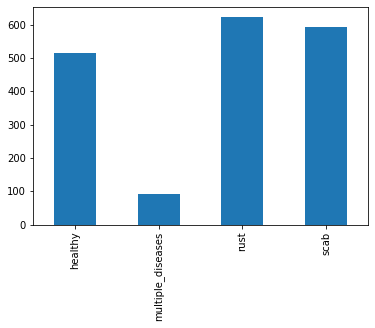

In [50]:
#lets look at the label counts
#lowest count is multiple_disease
LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']
train_df[LABELS].sum().plot(kind='bar')

In [ ]:
#all the other classes except multiple_diseases are about equal. Multiple_diseases is a bit underrepresented
round((train_df[LABELS].sum()/(train_df[LABELS].sum().sum()))*100, 2)

healthy              28.34
multiple_diseases     5.00
rust                 34.16
scab                 32.51
dtype: float64

In [52]:
#lets make a label column
train_df['label'] = train_df[LABELS].idxmax(1)

In [53]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

# Data and Dataloader

In [58]:
SEED = 42
set_seed(42)
IMG_SIZE = 224
BS = 64
ARCH = resnet34

In [66]:
db = DataBlock(
                blocks=(ImageBlock, CategoryBlock), 
                getters=[ColReader('image_id', pref=IMG_DIR, suff='.jpg'), ColReader('label')], 
                splitter=RandomSplitter(valid_pct=0.2, seed=SEED),
                item_tfms=Resize(IMG_SIZE),
                # TODO: missing image normalization???
                batch_tfms=aug_transforms()
              )

In [60]:
dls = db.dataloaders(source=train_df, bs=BS)

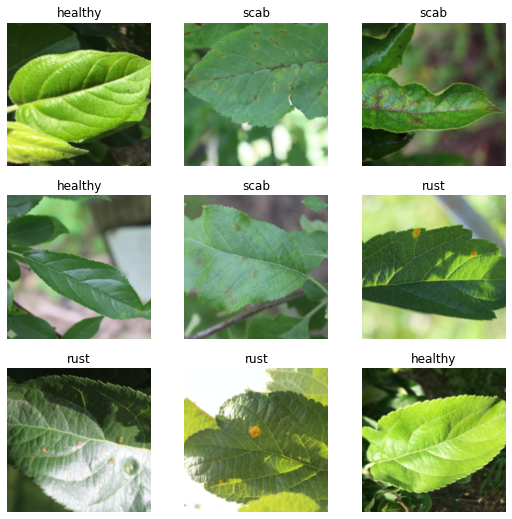

In [61]:
dls.show_batch()

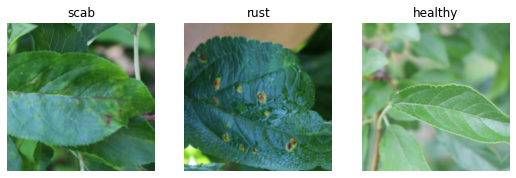

In [62]:
dls.train.show_batch(max_n=3)

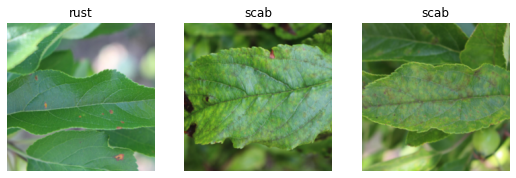

In [63]:
dls.valid.show_batch(max_n=3)

In [64]:
dls.col_reader

(#2) [ColReader -- {'cols': 'image_id', 'pref': Path('/content/drive/MyDrive/fastai/data/plant-pathology/images'), 'suff': '.jpg', 'label_delim': None}:
encodes: decodes: ,ColReader -- {'cols': 'label', 'pref': '', 'suff': '', 'label_delim': None}:
encodes: decodes: ]

In [65]:
dls.valid.bs

64

# Metric

In [67]:
# the metric was copied from https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(LABELS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

# Training

In [68]:
learn = cnn_learner(dls, ARCH, 
                    # loss_func=CrossEntropyLossFlat(), # TODO: Are we using correct optimization function? In Kaggle eval desc it is AUC that they compare with
                    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0020892962347716093)

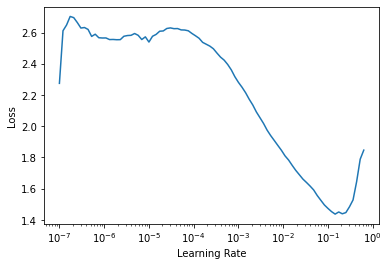

In [69]:
learn.lr_find()

In [70]:
LR = 2e-3 # from lr_finder

In [ ]:
learn.fine_tune(1, LR)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.188739,0.436316,0.835165,0.934493,01:15


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.595289,0.321865,0.868132,0.961806,01:16


In [ ]:
learn.fit_one_cycle(5, slice(1e-6, LR))

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.407044,0.300737,0.895604,0.974371,01:18
1,0.357566,0.259842,0.901099,0.981815,01:17
2,0.350290,0.191044,0.912088,0.983187,01:15
3,0.318675,0.231447,0.912088,0.984727,01:15
4,0.277468,0.258088,0.928571,0.985079,01:15


**Saved model**

In [ ]:
learn.save(f"{DATA_DIR}/3_cls_{ARCH.__name__}_model")

Path('/content/drive/MyDrive/fastai/data/plant-pathology/3_cls_resnet50_model.pth')

In [ ]:
learn = learn = cnn_learner(dls, ARCH, 
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]).to_fp16()

learn = learn.load(f"{DATA_DIR}/3_cls_{ARCH.__name__}_model")

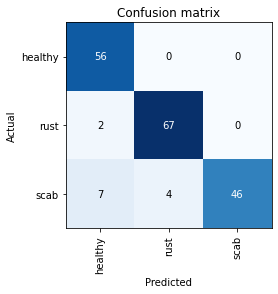

In [ ]:
#model is actually missing interp scab as health
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

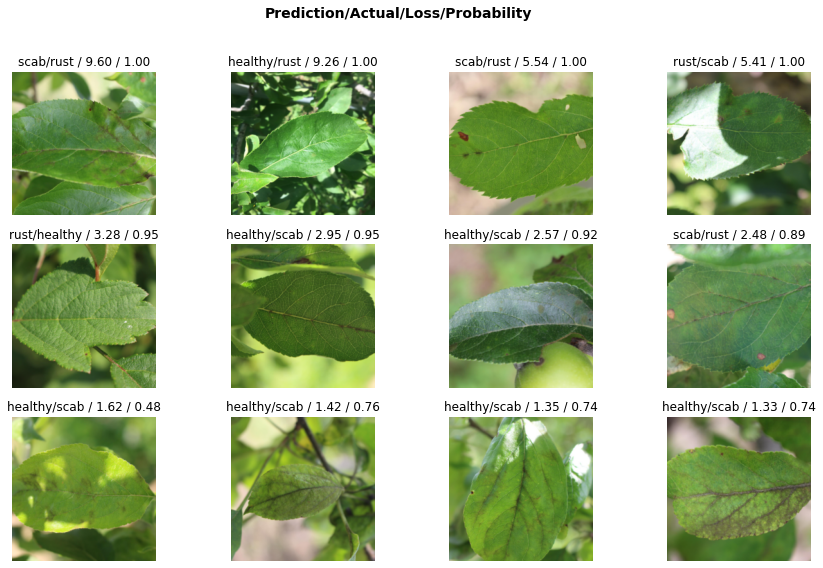

In [ ]:
#understandable why multiple_disease looks like rust
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
test_preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)

In [ ]:
# recreate multiple_diseases column removed for training the model

sub_df['multiple_diseases'] = sub_df['rust'] * sub_df['scab']

In [ ]:
def normalize_row(row):
  """
  Normalizes class probabilities to add up to 1.0
  """
  sum = row['healthy'] + row['rust'] + row['scab'] + row['multiple_diseases']

  row['healthy'] /= sum
  row['rust'] /= sum
  row['scab'] /= sum
  row['multiple_diseases'] /= sum

  return row

# as new column was added, we need to normalize probabilities for each row
sub_df = sub_df.apply(normalize_row, axis=1)

In [ ]:
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]

In [ ]:
sub_df.to_csv(f'{DATA_DIR}/submission_3_cls_{ARCH.__name__}.csv', index=False)

# Things we can try
1. try other (bigger) architecture -->maybe from timm or torchvision
2. other image augmentation
3. factoring the multiple_disease label data by different factors
4. in the above learner, it confuses btw rusty/multiple_disease and scab/healthy (maybe we can look into this also)


#interesting concepts used in [this notebook](https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763) 

1. multilabel kfold crossvalidation
2. data augmentation (?) - increasing the amount of lowest label data 
3. transfer learning - densenet
4. freeze/unfreeze training
6. LabelSmoothingCrossEntropy
5. to_fp16 - understand this was mentioned in the "bags of tricks for image classification with cnn paper" (anyone has any resources to learn about it)

#other interesting concepts
1. AccumMetric - how does this work?? 